# Hands-on Image Processing with Python
## Chapter 6: Extracting Image Features and Descriptors

In [1]:
# Author: Sandipan Dey

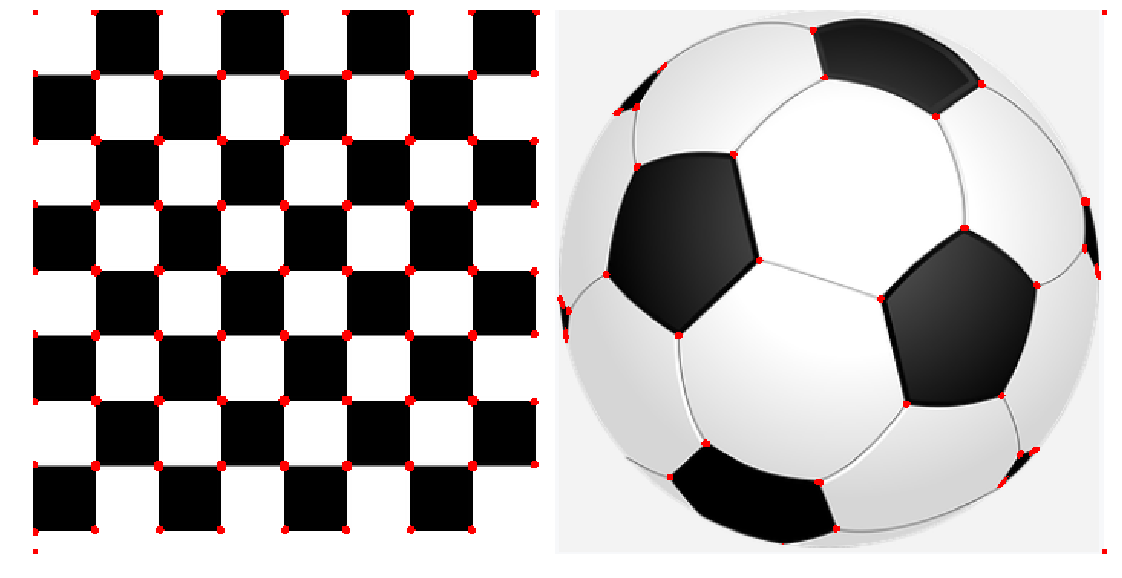

In [1]:
% matplotlib inline

from matplotlib import pylab as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks, peak_local_max, corner_kitchen_rosenfeld
from skimage.morphology import dilation, disk
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
import numpy as np

image = imread('../new images/chess.png') # RGBA image
image_gray = rgb2gray(image)
coords = corner_harris(image_gray, k =0.001) 
image[coords>0.01*coords.max()]=[255,0,0,255]
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis('off')
plt.show()

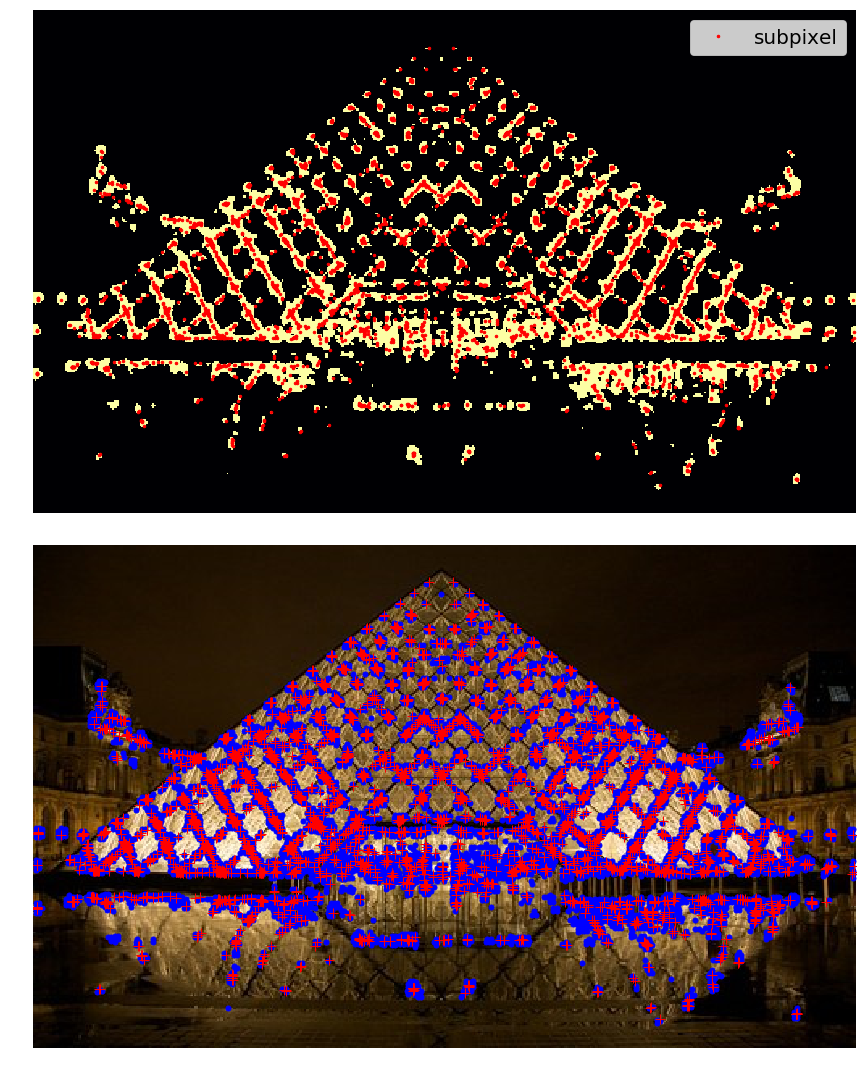

In [4]:
image = imread('../new images/pyramids2.jpg')
image_gray = rgb2gray(image)

coords = corner_harris(image_gray, k =0.001)
coords[coords > 0.01*coords.max()] = 255
c_coords = corner_peaks(coords)
coords_subpix = corner_subpix(image_gray, c_coords, window_size=11)

plt.figure(figsize=(15,15))
plt.subplot(211) 
plt.imshow(coords, cmap='inferno')
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], 'r.', markersize=5, label='subpixel')
plt.legend(prop={'size': 20})
plt.axis('off')
plt.subplot(212) 
plt.imshow(image, interpolation='nearest')
plt.plot(c_coords[:, 1], c_coords[:, 0], 'bo', markersize=5)
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], 'r+', markersize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

#coords = np.clip(corner_kitchen_rosenfeld(image),0,1)
#fig, ax = plt.subplots(figsize=(15,15))
#ax.imshow(image + coords, interpolation='nearest', cmap=plt.cm.gray)
#plt.show()

In [ ]:
from __future__ import division, print_function
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from skimage.io import imread

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

img = imread('../my images/me2.jpg')
# For speed, only extract the two first types of features
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using dask. This allows using multiple CPUs for
# the computation step
X = delayed(extract_feature_image(img, feature_types)
            for img in images)
# Compute the result using the "processes" dask backend
t_start = time()
X = np.array(X.compute(scheduler='processes'))
time_full_feature_comp = time() - t_start
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features to be able to select the most salient.
feature_coord, feature_type = \
        haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                                feature_type=feature_types)

In [ ]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = rgb2gray(data.astronaut())
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img3 = tf.warp(img1, tform)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: overflow encountered in longlong_scalars
C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\ipykernel\__main__.py:63: RuntimeWarning: overflow encountered in longlong_scalars


(0.8, 0.9) [ 120.  -20.] 0.09999999999999999
(0.8982412101241938, 0.8072777593937368) [ -20.45123966  114.92297156] -0.10225420334222493
(0.9001524425730119, 0.8000362790749188) [ -19.87491292  119.83016533] -0.09990858564132575


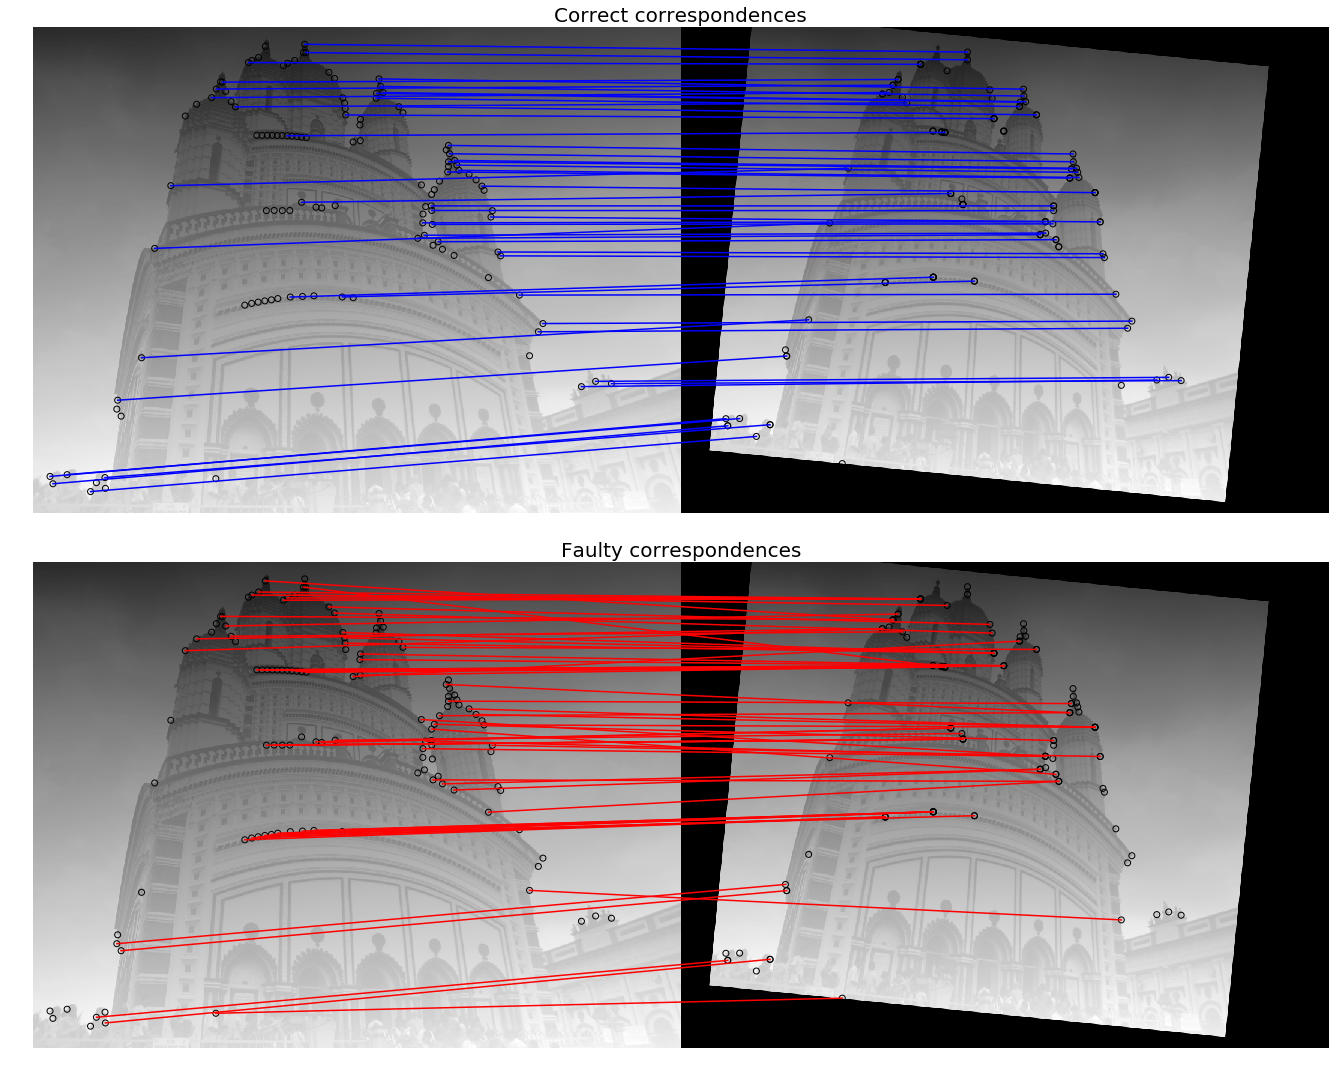

In [273]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks, plot_matches)
from skimage.transform import warp, SimilarityTransform, AffineTransform, resize
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

# generate synthetic checkerboard image and add gradient for the later matching
book = rgb2gray(img_as_float(imread('../my images/temple.jpg')))
#book = img_as_float(data.checkerboard())
img_orig = np.zeros(list(book.shape) + [3])
img_orig[..., 0] = book
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
#shift_y, shift_x = np.array(img_orig.shape[:2]) / 2.
#tf_rotate = SimilarityTransform(rotation=np.deg2rad(30))
#tf_shift = SimilarityTransform(translation=[-shift_x, -shift_y])
#tf_shift_inv = SimilarityTransform(translation=[shift_x, shift_y])

#img_warped = warp(img_orig, (tf_shift + (tf_rotate + tf_shift_inv)).inverse, output_shape=img_orig.shape)

tform = AffineTransform(scale=(0.8, 0.9), rotation=0.1, translation=(120, -20))
img_warped = warp(img_orig, tform.inverse, output_shape=img_orig.shape)
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords = corner_harris(img_orig_gray)
coords[coords > 0.01*coords.max()] = 1
coords_orig = corner_peaks(coords, threshold_rel=0.0001,
                           min_distance=5)
coords = corner_harris(img_warped_gray)
coords[coords > 0.01*coords.max()] = 1
coords_warped = corner_peaks(coords,
                             threshold_rel=0.0001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped, window_size=9)

def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=3):
    r, c = np.round(coord).astype(np.intp)
    #print(r, c, img_orig.shape)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        #if cr-window_ext > coords_warped.shape[0] or cr-window_ext < coords_warped.shape[1]: continue
        #print(cr, cc)
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        if window_orig.shape == window_warped.shape:
            SSD = np.sum(weights * (window_orig - window_warped)**2)
            SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs) if len(SSDs) > 0 else -1
    return coords_warped_subpix[min_idx] if min_idx >= 0 else [None]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    coord1 = match_corner(coord)
    if any(coord1) and len(coord1) > 0 and not all(np.isnan(coord1)):
        src.append(coord)
        dst.append(coord1)
src = np.array(src)
dst = np.array(dst)
#print(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print(tform.scale, tform.translation, tform.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,15))

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences', size=20)

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences', size=20)

fig.tight_layout()

plt.show()

In [ ]:
from skimage import data, io
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = rgb2gray(io.imread('images/lena.jpg')) #data.astronaut())
tform = tf.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
img2 = tf.warp(img1, tform)
img3 = tf.rotate(img1, 25)

coords1, coords2, coords3 = corner_harris(img1), corner_harris(img2), corner_harris(img3)
coords1[coords1 > 0.01*coords1.max()] = 1
coords2[coords2 > 0.01*coords2.max()] = 1
coords3[coords3 > 0.01*coords3.max()] = 1

keypoints1 = corner_peaks(coords1, min_distance=5)
keypoints2 = corner_peaks(coords2, min_distance=5)
keypoints3 = corner_peaks(coords3, min_distance=5)

extractor = BRIEF()

extractor.extract(img1, keypoints1)
keypoints1 = keypoints1[extractor.mask]
descriptors1 = extractor.descriptors

extractor.extract(img2, keypoints2)
keypoints2 = keypoints2[extractor.mask]
descriptors2 = extractor.descriptors

extractor.extract(img3, keypoints3)
keypoints3 = keypoints3[extractor.mask]
descriptors3 = extractor.descriptors

plt.subplot(211)
plt.imshow(descriptors1)
plt.subplot(212)
plt.imshow(descriptors2)
plt.show()

print(descriptors1.shape, descriptors2.shape)

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)


fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
images = [np.zeros((2, 2)), np.zeros((2, 2)),
          np.zeros((3, 3)), np.zeros((3, 3)),
          np.zeros((2, 2))]

feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

fig, axs = plt.subplots(3, 2)
for ax, img, feat_t in zip(np.ravel(axs), images, feature_types):
    coord, _ = haar_like_feature_coord(img.shape[0], img.shape[1], feat_t)
    haar_feature = draw_haar_like_feature(img, 0, 0,
                                          img.shape[0],
                                          img.shape[1],
                                          coord,
                                          max_n_features=1,
                                          random_state=0)
    ax.imshow(haar_feature)
    ax.set_title(feat_t)
    ax.set_axis_off()

fig.suptitle('The different Haar-like feature descriptors')
plt.show()

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('my images/books.png',0) # queryImage
img2 = cv2.imread('my images/book.png',0) # trainImage

# Initiate SIFT detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:200], None, flags=2)
plt.imshow(img3), plt.show()
'''

'''
import numpy as np
import cv2
from matplotlib import pyplot as plt
img1 = cv2.imread('my images/books.png',0) # queryImage
img2 = cv2.imread('my images/book.png',0) # trainImage
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create() #cv2.SIFT()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
#ratios = np.linspace(0.65, 0.85, 4)
#for i in range(n)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3),plt.show()

In [ ]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('C:/Softwares/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('C:/Softwares/opencv/data/haarcascades/haarcascade_frontalface_alt_tree.xml')
#face_cascade = cv2.CascadeClassifier('C:/Softwares/opencv/data/haarcascades/haarcascade_mcs_upperbody.xml')
#eye_cascade = cv2.CascadeClassifier('C:/Softwares/opencv/data/haarcascades/haarcascade_eye.xml')
eye_cascade = cv2.CascadeClassifier('C:/Softwares/opencv/data/haarcascades//haarcascade_eye_tree_eyeglasses.xml')

img = cv2.imread('my images/me11.jpg')
#img = cv2.imread('new images/monalisa.jpg')
#print(np.max(img))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    print(eyes)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

cv2.imwrite('me1_haar.jpg', img)

In [ ]:
import cv2
import numpy as np

filename = 'new images/chess.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

cv2.imwrite('eiffeltower_harris.jpg', img)

ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

cv2.imwrite('subpixel5.png',img)

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('my images/books.png',0) # queryImage
img2 = cv2.imread('my images/book.png',0) # trainImage

# Initiate SIFT detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:200], None, flags=2)
plt.imshow(img3), plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, io
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


image = color.rgb2gray(img_as_ubyte(io.imread('new images/FjOll.png'))) #data.coins()[160:230, 70:270]))
edges = canny(image, sigma=1)

hough_radii = [6]
hough_res = hough_circle(edges, hough_radii)

# select most prominent 25 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=20)

# Draw circles
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    print(center_y, center_x, radius)
    image[circy, circx] = (255, 0, 0)

ax.imshow(image)
plt.show()